IMPORTING RELEVANT LIBRARIES

In [37]:
# Settings
import warnings


# Data Wrangling
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns


#Preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LinearRegression

"""#Regression models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
"""
# Evaluation Metric
from sklearn.metrics import mean_absolute_error


warnings.simplefilter(action="ignore", category=FutureWarning)


PREPARE DATA

Import

In [38]:
def wrangle(filename):
    """
    This function reads the data from a csv file, cleans it, and returns a cleaned dataframe.
    """
    # Read the data
    df = pd.read_csv(filename)

    # Drop duplicates
    df = df.drop_duplicates()

    
    # Subsetting for properties in Lagos
    mask_lagos = df["state"] == "Lagos"

    # Apply the Lagos filter to get properties only in Lagos state
    df = df[mask_lagos]
    

    
    return df


In [39]:
df = wrangle(r"C:\Users\micah\OneDrive\Desktop\Data Science Projects\Real Estate in Lagos\data\nigeria_houses_data.csv")

In [ ]:
# Add this after df = wrangle(...) but before splitting into train/test


def add_location_price_tiers(df):
    """Creates location-based price tiers for properties"""
    # Group properties by town and calculate price statistics
    town_stats = df.groupby("town")["price"].agg(["median"]).reset_index()

    # Create town price tier dictionary based on town median prices
    town_tiers = {}
    all_towns_median = df["price"].median()

    for _, row in town_stats.iterrows():
        town = row["town"]
        median = row["median"]

        if median > (all_towns_median * 2):
            town_tiers[town] = "Premium"
        elif median > all_towns_median:
            town_tiers[town] = "Above Average"
        elif median > (all_towns_median * 0.5):
            town_tiers[town] = "Average"
        else:
            town_tiers[town] = "Value"

    # Add town tier feature
    df["location_tier"] = df["town"].map(town_tiers)

    # Print distribution to verify
    print(df["location_tier"].value_counts())

    return df


# Apply the function
df = add_location_price_tiers(df)


location_tier
Above Average    4496
Average          1656
Value            1214
Premium          1205
Name: count, dtype: int64


In [41]:
df.head()

,bedrooms,bathrooms,toilets,parking_space,title,town,state,price,location_tier
2,4.0,5.0,5.0,4.0,Detached Duplex,Lekki,Lagos,120000000.0,Above Average
3,4.0,4.0,5.0,6.0,Detached Duplex,Ajah,Lagos,40000000.0,Average
4,4.0,4.0,5.0,2.0,Semi Detached Duplex,Lekki,Lagos,75000000.0,Above Average
5,5.0,5.0,6.0,1.0,Detached Duplex,Lekki,Lagos,450000000.0,Above Average
6,4.0,5.0,5.0,4.0,Detached Duplex,Lekki,Lagos,65000000.0,Above Average


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8571 entries, 2 to 24324
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       8571 non-null   float64
 1   bathrooms      8571 non-null   float64
 2   toilets        8571 non-null   float64
 3   parking_space  8571 non-null   float64
 4   title          8571 non-null   object 
 5   town           8571 non-null   object 
 6   state          8571 non-null   object 
 7   price          8571 non-null   float64
 8   location_tier  8571 non-null   object 
dtypes: float64(5), object(4)
memory usage: 669.6+ KB


In [43]:
df.select_dtypes("object").nunique()


title             7
town             48
state             1
location_tier     4
dtype: int64

<Axes: >

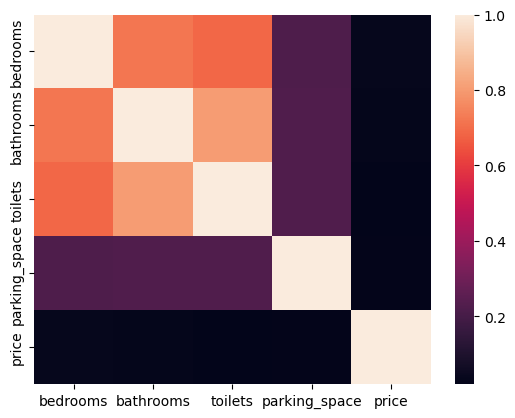

In [44]:
#Heatmap of correlations for checking issues of multicollinearity
corr = df.select_dtypes("number").corr()
sns.heatmap(corr)

<Axes: xlabel='price'>

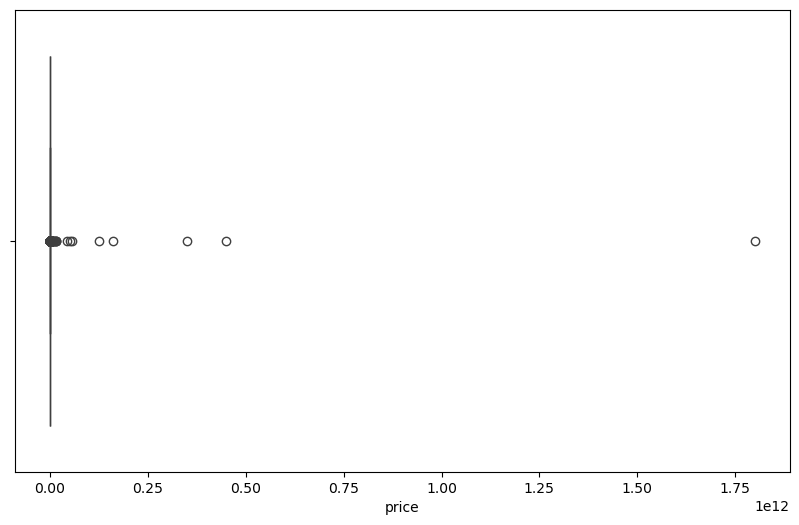

In [45]:
#Boxplot of the target variable
plt.figure(figsize=(10, 6))
sns.boxplot(x=df["price"])

<Axes: xlabel='price', ylabel='Count'>

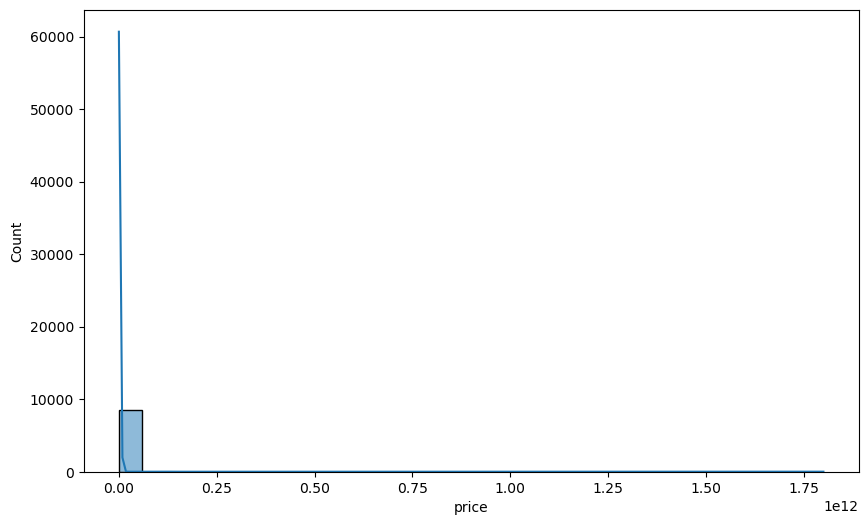

In [46]:
#histogram of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(df["price"], bins=30, kde=True)

                    town         price
23                 Ikoyi  1.800000e+12
33                 Lekki  3.500000e+11
16          Ifako-Ijaiye  5.500000e+10
2                   Ajah  5.000000e+10
14           Ibeju Lekki  1.500000e+10
46  Victoria Island (VI)  6.000000e+09
20                 Ikeja  1.440000e+09
35              Maryland  1.400000e+09
5                  Apapa  7.500000e+08
29                 Isolo  6.500000e+08
32          Lagos Island  5.000000e+08
24               Ilupeju  3.500000e+08
45              Surulere  3.500000e+08
43                Oshodi  3.200000e+08
47                  Yaba  3.200000e+08
34                Magodo  3.000000e+08
22                Ikotun  2.700000e+08
44               Shomolu  2.500000e+08
4           Amuwo Odofin  2.500000e+08
12               Gbagada  2.500000e+08
37                 Ogudu  2.300000e+08
39                 Ojodu  2.000000e+08
21               Ikorodu  2.000000e+08
1                  Agege  1.850000e+08
28          Isheri North 

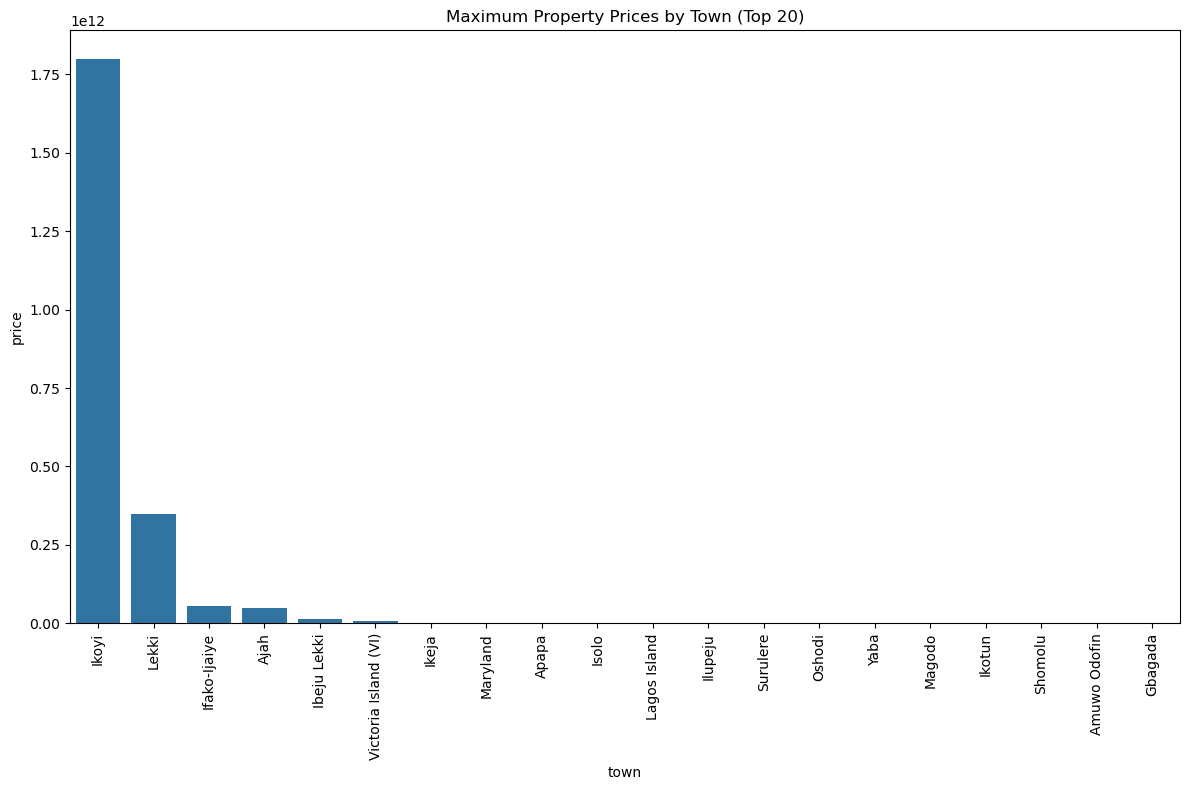

In [47]:
#Each town and their max prices 
# Group by town and calculate max price for each town
town_max_prices = df.groupby("town")["price"].max().reset_index()

# Sort by max price in descending order
town_max_prices = town_max_prices.sort_values(by="price", ascending=False)

# Display the results
print(town_max_prices)

# Optional: Create a bar plot for visual representation
plt.figure(figsize=(12, 8))
sns.barplot(x="town", y="price", data=town_max_prices.head(20))
plt.xticks(rotation=90)
plt.title("Maximum Property Prices by Town (Top 20)")
plt.tight_layout()
plt.show()

SPLIT

In [48]:
target = "price"
y = df[target]
X = df.drop(columns=[target])

In [49]:
# Randomized train set and test set split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


BUILD MODEL

BASELINE

In [50]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
mae = mean_absolute_error(y_train, y_pred_baseline)
print("Mean apt price:", round(y_mean, 2))

print("Baseline MAE:", mae)


Mean apt price: 569990136.31
Baseline MAE: 851437202.898019


ITERATE

In [51]:
# Linear Regression model
model_lr = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(),
    LinearRegression()
)
model_lr.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder()),
                ('simpleimputer', SimpleImputer()),
                ('linearregression', LinearRegression())])

In [52]:
#Training Set Performance Evaluation
y_train_pred = model_lr.predict(X_train)
mae_train = mean_absolute_error(y_train, y_train_pred)
print("Training Set MAE:", mae_train)

Training Set MAE: 1565224997.9155564


In [53]:
# Test Set Performance Evaluation
y_pred = model_lr.predict(X_test)
mae_test = mean_absolute_error(y_test, y_pred)
print("Test set MAE:", mae_train)

ValueError: Found unknown categories ['Agbara-Igbesa'] in column 5 during transform

In [ ]:
#Ridge Regression model
model_rid = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(),
    Ridge()
)
model_rid.fit(X_train, y_train)

In [ ]:
# Training Set Performance Evaluation
y_train_pred = model_rid.predict(X_train)
mae_train = mean_absolute_error(y_train, y_train_pred)
print("Training Set MAE:", mae_train)


In [ ]:
# Test Set Performance Evaluation
y_pred = model_rid.predict(X_test)
mae_test = mean_absolute_error(y_test, y_pred)
print("Test set MAE:", mae_train)


In [ ]:
# Set up the dictionary of models, each in its own pipeline
models = {
    "Linear Regression": make_pipeline(
        OneHotEncoder(handle_unknown="ignore", sparse_output=False),
        SimpleImputer(),
        LinearRegression(),
    ),
    "Ridge Regression": make_pipeline(
        OneHotEncoder(handle_unknown="ignore", sparse_output=False),
        SimpleImputer(),
        Ridge(alpha=1.0),
    ),
    "Random Forest": make_pipeline(
        OneHotEncoder(handle_unknown="ignore", sparse_output=False),
        SimpleImputer(),
        RandomForestRegressor(random_state=42),
    ),
    "LightGBM": make_pipeline(
        OneHotEncoder(handle_unknown="ignore", sparse_output=False),
        SimpleImputer(),
        LGBMRegressor(random_state=42),
    ),
    "XGBoost": make_pipeline(
        OneHotEncoder(handle_unknown="ignore", sparse_output=False),
        SimpleImputer(),
        XGBRegressor(random_state=42),
    ),
}

# Fit and evaluate each model
results = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate metrics
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    # Store results
    results[name] = {
        "Train MAE": train_mae,
        "Test MAE": test_mae,
    }

    # Print results
    print(f"{name}:")
    print(f"  Train Mean Absolute Error: {train_mae:.4e}")
    print(f"  Test Mean Absolute Error: {test_mae:.4e}")
    print("-" * 50)

# Create a DataFrame of results for easy comparison
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df)
